In [1]:
"""
Created on Wed Aug 4 17:50:06 2021

@author: Amol & Dwyer
"""

# set TF GPU memory growth so that it doesn't hog everything at once
import tensorflow as tf
physical_devices = tf.config.list_physical_devices('GPU')
tf.config.experimental.set_memory_growth(physical_devices[0], True)

import os
import numpy as np
from optuna_train import *
debug_mode = True  # faster experiments for debugging

def print_scientific_notation(number):
    power = int(np.log(number)/np.log(10))
    print(f"Scientific Notation: {(loss/10**power)}*10^{power}")

In [2]:
#Prepare the DataFrame that will be used downstream
dp = DataPreparer()
dp.createPCAs()
dp.sparsePCAs()
df = dp.getDataframe()

# currently passing dp eventually we want to abstract all the constants into 1 class
dm = DataManager(df, dp)

In [3]:
""" prepare PCDNNV2 for loading (from prior experiments) """

exprExec = PCDNNV2ExperimentExecutor()
exprExec.debug_mode = debug_mode
exprExec.setModelFactory(PCDNNV2ModelFactory())

Parent DNNModelFactory Instantiated
Parent DNNModelFactory Instantiated


2022-07-28 00:45:30.978588: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-07-28 00:45:31.369089: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13571 MB memory:  -> device: 0, name: Quadro RTX 5000, pci bus id: 0000:65:00.0, compute capability: 7.5


## Rapid Model Testing: 
### (requires setting up PCDNNV2 for loading)

In [4]:
# fix seeds
import random
import numpy as np
random.seed(0)
np.random.seed(0)
tf.random.set_seed(0)

dataType = 'randomequaltraintestsplit' #'frameworkincludedtrainexcludedtest'
inputType = 'AllSpeciesAndZmix'
dependants = 'NoDependants'
dataSetMethod = f'{inputType}_{dataType}_{dependants}'
opscaler=ipscaler="MinMaxScaler"# 'PositiveLogNormal'
#opscaler=None
ZmixPresent = 'N'
concatenateZmix = 'N'
kernel_constraint = 'Y'
kernel_regularizer = 'N'
activity_regularizer = 'N'
noOfCpv = 4
noOfNeurons = 53

exprExec.modelFactory.loss='mae'
exprExec.modelFactory.activation_func='selu'
exprExec.modelFactory.dropout_rate=0.0
exprExec.debug_mode = False
exprExec.use_dependants = True
exprExec.use_dynamic_pred = True
exprExec.epochs_override = 100
exprExec.batch_size = 64
exprExec.n_models_override = 1

# initialize experiment executor...
exprExec.dm = dm
exprExec.df_experimentTracker = pd.DataFrame()
exprExec.modelType = 'PCDNNV2'

history = exprExec.executeSingleExperiment(noOfNeurons,dataSetMethod,dataType,inputType,ZmixPresent=ZmixPresent,
                                           noOfCpv=noOfCpv,concatenateZmix=concatenateZmix,kernel_constraint=kernel_constraint,
                                           kernel_regularizer=kernel_regularizer,activity_regularizer=activity_regularizer,
                                           opscaler=opscaler, ipscaler=ipscaler)

--------------------self.build_and_compile_pcdnn_v2_model----------------------
len testing df:  9331
53 4 N Y N N
Model: "container_model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 species_input (InputLayer)     [(None, 53)]         0           []                               
                                                                                                  
 source_term_input (InputLayer)  [(None, 53)]        0           []                               
                                                                                                  
 emb_and_regression_model (Func  {'static_source_pre  350137     ['species_input[0][0]']          
 tional)                        diction': (None, 1)                                               
                                , 'dynamic_source_p                 

||                                                                                              ||
|| dropout_7 (Dropout)        (None, 64)           0           []                               ||
||                                                                                              ||
|| dense_8 (Dense)            (None, 32)           2080        []                               ||
||                                                                                              ||
|| dropout_8 (Dropout)        (None, 32)           0           []                               ||
||                                                                                              ||
|| dynamic_source_prediction (Den  (None, 4)       132         []                               ||
|| se)                                                                                          ||
||                                                                                              ||
|| static_

/home/dwyerdei/.conda/envs/rom-project/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but MinMaxScaler was fitted without feature names
  warnings.warn(
/home/dwyerdei/.conda/envs/rom-project/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but MinMaxScaler was fitted without feature names
  warnings.warn(


73/73 [==============================] - 3s 19ms/step - loss: 0.3486 - dynamic_source_prediction_loss: 0.1522 - static_source_prediction_loss: 0.1964 - dynamic_source_prediction_R2_split: -322844256.0000 - dynamic_source_prediction_source_pred_mean: 1.7194 - dynamic_source_prediction_source_true_mean: 1.7510 - static_source_prediction_mae: 0.1964 - static_source_prediction_mse: 0.1088 - static_source_prediction_R2: -32.9121 - val_loss: 0.1944 - val_dynamic_source_prediction_loss: 0.1286 - val_static_source_prediction_loss: 0.0658 - val_dynamic_source_prediction_R2_split: -124539960.0000 - val_dynamic_source_prediction_source_pred_mean: 1.8129 - val_dynamic_source_prediction_source_true_mean: 1.7749 - val_static_source_prediction_mae: 0.0658 - val_static_source_prediction_mse: 0.0110 - val_static_source_prediction_R2: -0.8277
Epoch 2/100
73/73 [==============================] - 1s 16ms/step - loss: 0.2316 - dynamic_source_prediction_loss: 0.1038 - static_source_prediction_loss: 0.1278 -

KeyboardInterrupt: 

## Results Plotting & Analysis

In [5]:
import model_analyzer.model_analysis as model_analysis
import importlib; importlib.reload(model_analysis)

bestModel, experimentSettings = exprExec.modelFactory.openBestModel()
bestModel = exprExec.modelFactory.getEmbRegressor()
#dm.createTrainTestData(experimentSettings['dataSetMethod'],experimentSettings['noOfCpv'], experimentSettings['ipscaler'], experimentSettings['opscaler'])
dm = experimentSettings['data_manager']
dp = dm.constants # god only knows why this is called "constants"
history = experimentSettings['history']
del experimentSettings['data_manager']
del experimentSettings['history'] # remove clutter from print

inspector = model_analysis.ModelInspector(exprExec.modelFactory, dm)
print(f'\nbestModel.input_shape: {bestModel.input_shape}')
print(f'\nexperimentSettings: {experimentSettings}')
experimentSettings['history'] = history # put it pack

len testing df:  1452
input names: ['input_1']
output names (before pruning): ['dynamic_source_prediction', 'static_source_prediction']
['zmix', 'cpv1', 'cpv2', 'cpv3', 'cpv4', 'cpv5', 'cpv6', 'cpv7', 'cpv8', 'cpv9']

bestModel.input_shape: [(None, 67), (None, 1)]

experimentSettings: {'dataSetMethod': 'AllSpecies_randomequaltraintestsplit_AllDependants', 'ipscaler': None, 'opscaler': 'StandardScaler', 'noOfCpv': 9, 'ZmixPresent': 'Y', 'concatenateZmix': 'Y', 'kernel_constraint': 'Y', 'kernel_regularizer': 'Y', 'activity_regularizer': 'N', 'input_data_cols': ['YiH', 'YiO2', 'YiO', 'YiOH', 'YiH2', 'YiH2O', 'YiHO2', 'YiH2O2', 'YiCO', 'YiCO2', 'YiHCO', 'YiCH', 'YiT-CH2', 'YiCH3', 'YiCH2O', 'YiHCCO', 'YiC2H', 'YiCH2CO', 'YiC2H2', 'YiS-CH2', 'YiC2H4', 'YiCH3OH', 'YiCH2OH', 'YiCH3O', 'YiCH4', 'YiCH3O2', 'YiC2H3', 'YiC2H5', 'YiCH2CHO', 'YiCH3CHO', 'YiH2C2', 'YiC2H5O', 'YiN-C3H7', 'YiC2H6', 'YiC3H8', 'YiC3H6', 'YiC3H3', 'YiP-C3H4', 'YiA-C3H4', 'YiS-C3H5', 'YiC2H3CHO', 'YiA-C3H5', 'YiC2O', 'YiC

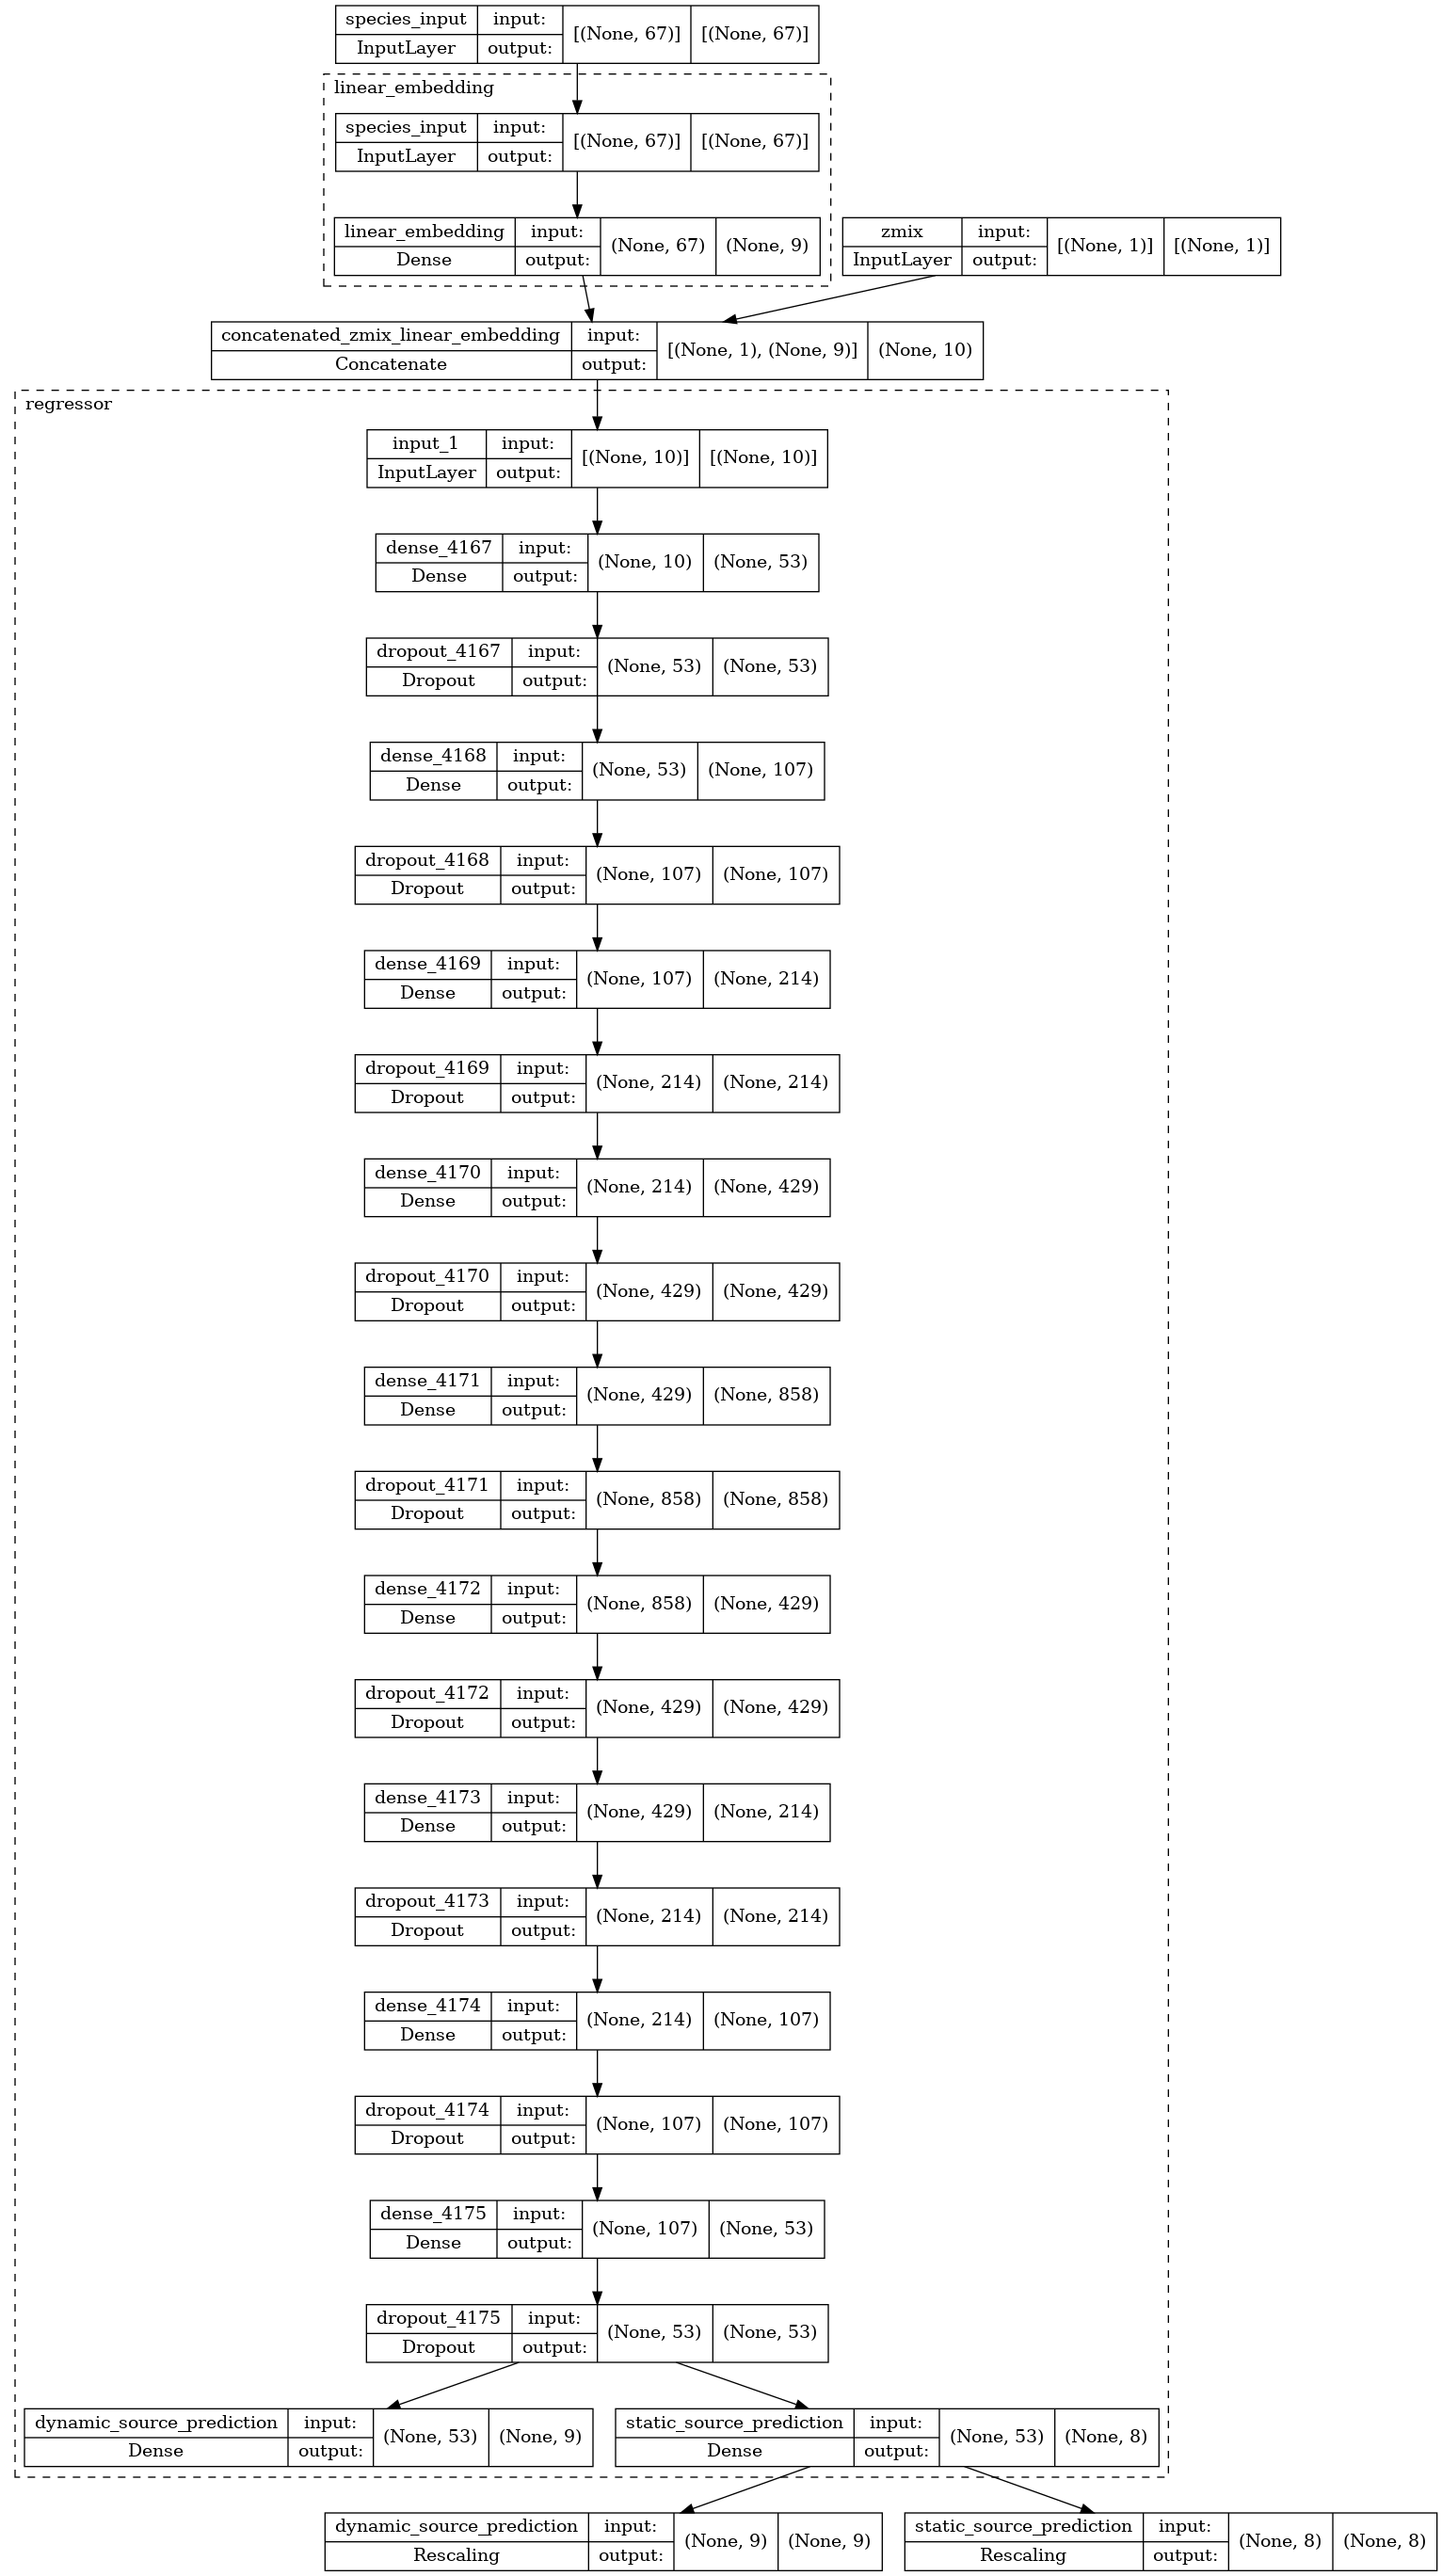

In [6]:
tf.keras.utils.plot_model(bestModel, expand_nested=True, show_shapes=True)

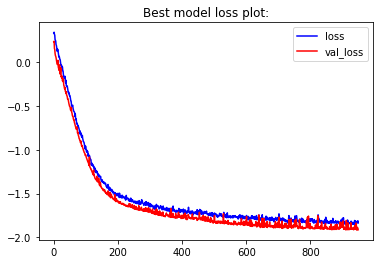

Best Model dev R^2 (combined):  0.9706506389689524
Best Model val static R^2: 0.9307761192321777
Best Model val dynamic R^2: 0.9292237758636475


In [7]:
import matplotlib.pyplot as plt
plt.plot(experimentSettings['history']['loss'][50:], color='blue')
plt.plot(experimentSettings['history']['val_loss'][50:], color='red')
plt.legend(labels=['loss', 'val_loss'])
plt.title('Best model loss plot:')
plt.show()
print('Best Model dev R^2 (combined): ', experimentSettings['model_R2'])
print('Best Model val static R^2:', experimentSettings['val_losses']['static_source_prediction_R2'])
print('Best Model val dynamic R^2:', experimentSettings['val_losses']['dynamic_source_prediction_R2_split'])

cpv5; 3.967364e+00 +/- 2.033088e-01
cpv1; 1.690965e+00 +/- 1.080598e-01
zmix; 1.290117e+00 +/- 1.011125e-01
cpv7; 8.454020e-01 +/- 2.388671e-02
cpv3; 7.012284e-01 +/- 2.296824e-02
cpv8; 1.886182e-01 +/- 1.760038e-02
cpv4; 8.143412e-02 +/- 4.785274e-03
cpv9; 4.295069e-02 +/- 4.755802e-03
cpv2; 6.878181e-03 +/- 1.619352e-03
cpv6; -3.400339e-05 +/- 9.025446e-04


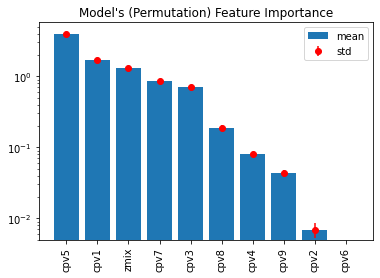

In [8]:
n_repeats = 5 if debug_mode else 20
inspector.plot_permutation_feature_importance(n_repeats=n_repeats)

             zmix      cpv1      cpv2          cpv3      cpv4      cpv5  \
min -6.116791e-16  0.019466  0.000115  6.499867e-07  0.021628  0.049688   
25%  2.601867e-06  0.134665  0.000157  1.505226e-06  0.021628  0.049688   
50%  1.673776e-03  0.146779  0.000157  5.680655e-04  0.021786  0.049976   
75%  8.494587e-02  0.147022  0.000190  1.975355e-02  0.026287  0.062498   
max  8.870626e-01  0.147023  0.023357  3.186210e-02  0.040471  0.096072   

         cpv6      cpv7      cpv8      cpv9  
min  0.005151  0.001114  0.001299  0.000274  
25%  0.013621  0.012909  0.001334  0.000274  
50%  0.014743  0.054458  0.001334  0.000433  
75%  0.014767  0.055289  0.002360  0.005253  
max  0.014767  0.055290  0.008690  0.009257  


/home/dwyerdei/.conda/envs/rom-project/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_partial_dependence is deprecated; Function `plot_partial_dependence` is deprecated in 1.0 and will be removed in 1.2. Use PartialDependenceDisplay.from_estimator instead
  warnings.warn(msg, category=FutureWarning)


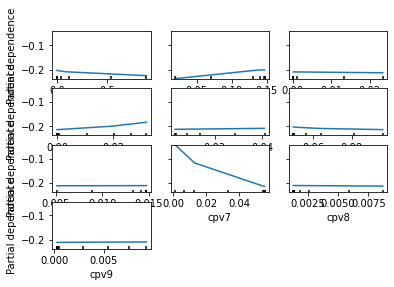

In [9]:
inspector.plot_partial_dependence()

#### Error Density by FlameId & XPos

Text(0.5, 1.0, 'Residual, Marginal Density plot:')

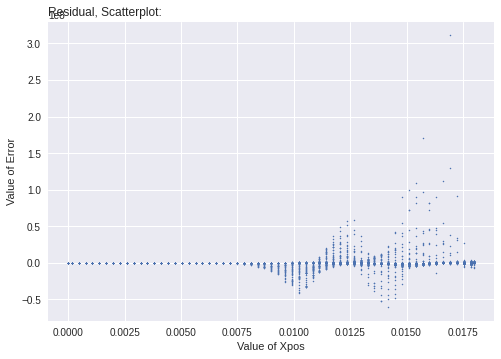

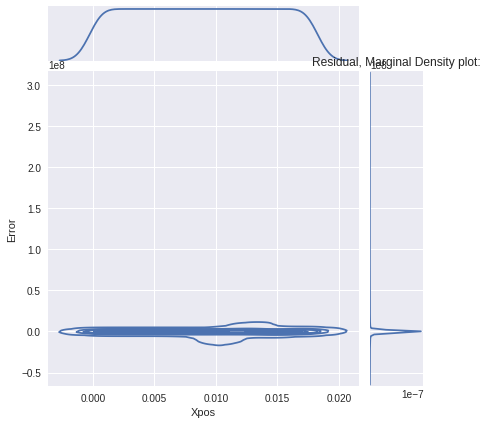

In [10]:
def getResiduals(Y,Y_pred):
    return Y-Y_pred

# TODO: Sanity check that this plots output ranges are correct? Seems like bug!
bestModel = exprExec.modelFactory.getEmbRegressor()

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

# libraries and data
plt.style.use('seaborn')

opscaler = dm.outputScaler
df = dp.getDataframe()
X, Y, Zmix, sources = dm.getAllData()
Y_pred = bestModel.predict({"species_input":X, "zmix":Zmix})['static_source_prediction']

# TODO: check should there be inverse transform here?
souener_pred = opscaler.inverse_transform(Y_pred)[:, dm.souener_index]
souener_actual = opscaler.inverse_transform(Y)[:, dm.souener_index]

#residual/error
residuals = getResiduals(souener_actual,souener_pred)
Xpos = df['Xpos']

plt_df = pd.DataFrame()
plt_df["Xpos"]=Xpos
plt_df["Error"] = residuals
# plot
plt.plot('Xpos', 'Error', data=plt_df, linestyle='', marker='o',markersize=1.5)
plt.xlabel('Value of Xpos')
plt.ylabel('Value of Error')
plt.title('Residual, Scatterplot:', loc='left')

# 2D density + marginal distribution:
sns.jointplot(x=plt_df.Xpos, y=plt_df.Error, kind='kde')
plt.title('Residual, Marginal Density plot:')

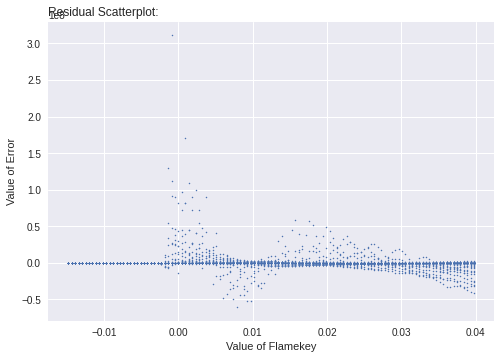

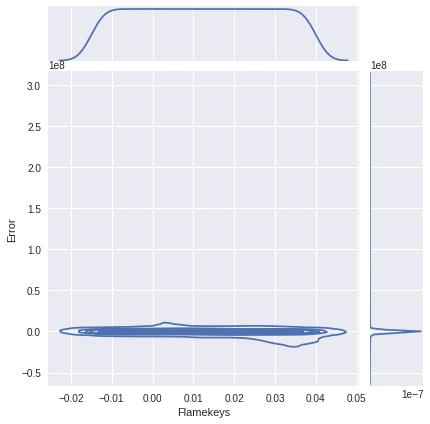

In [12]:
#residuals = getResiduals(Y_test_df['souener'].values,Y_pred_df['souener'].values)

flamekeys = df['flame_key']#np.append(halfData["flame_keys_test"],halfData["flame_keys_train"],axis=0)

plt_df = pd.DataFrame()
plt_df["Flamekeys"]=flamekeys
plt_df["Error"] = residuals
# plot
plt.plot( 'Flamekeys', 'Error', data=plt_df, linestyle='', marker='o',markersize=1.5)
plt.xlabel('Value of Flamekey')
plt.ylabel('Value of Error')
plt.title('Residual Scatterplot:', loc='left')

# 2D density + marginal distribution:
sns.jointplot(x=plt_df.Flamekeys, y=plt_df.Error, kind='kde')

Text(0.5, 1.0, 'Y histogram')

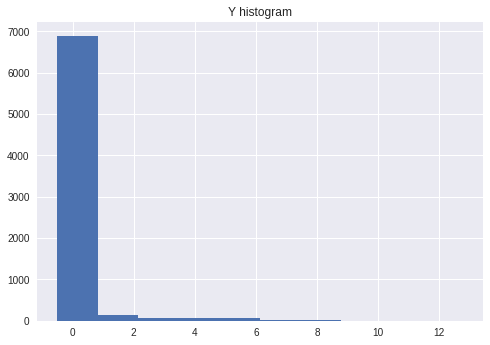

In [14]:
plt.hist(Y[:,0])
plt.title('Souener (scaled) histogram')

Text(0.5, 1.0, 'Souener histogram')

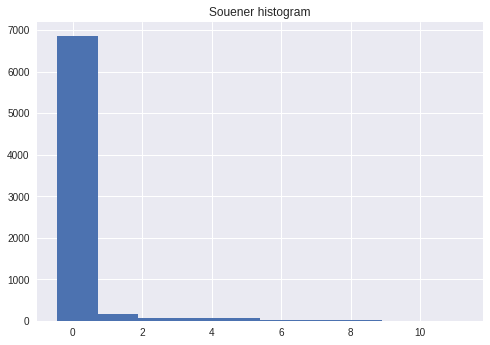

In [16]:
plt.hist(Y_pred[:,0])
plt.title('Souener_pred (scaled) histogram')